# arxive.org paper clustering system

This program will scrape the data from https:\\\arxiv.org and cluster them based on there simillarity. Then usnig T-SNE the clustered papers are plotted. 

## Scrape data from arxiv.org

In [1]:
from bs4 import BeautifulSoup
import requests

def extract_website_data(url):
    " Extract the data from arxiv.org. Input the web url"
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser') 
    links = soup.find_all('span',{'class':'list-identifier'})
    return soup, links

list_of_paper_links = []
page_links = []
def extract_paper_links():
    " Scrape the paper links from arxiv.org. Time out is created when the time for while loop exceed 20 second function aborted."
    
    counter = 0
    
    while counter <= 100:  #time.time() < timeout_start + timeout
        try:
            page_url = "https://arxiv.org/list/hep-ph/recent" + f'/list/hep-ph/pastweek?skip={counter}&show=25'
            page_links.append(page_url)
        except AttributeError:
            break
            
        soup, links = extract_website_data(page_url)
        
        for link in links:
            paper_url = 'https://arxiv.org' + link.a.get('href')
            list_of_paper_links.append(paper_url)  
            
        counter = counter + 25    
        
extract_paper_links()    
print(len(list_of_paper_links)) # the number of papers for clustering

121


In [2]:
def get_only_text(url):
    "Get the abtract and the title of papers"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "lxml")
    text = soup.find('blockquote', {'class':'abstract mathjax'}).text
    title = ' '.join(soup.title.stripped_strings)
    return title, text

In [3]:
list_of_summaries = []
list_of_titles = []
def generate_content(links):
    "Scrape the data from all the papers"
    for link in links:
        page_content = get_only_text(link)
        list_of_titles.append(page_content[0])
        list_of_summaries.append(page_content[1])

generate_content(list_of_paper_links)        

Create TF_IDF matrix to obtain word frequency 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer() # Creat TF_IDF mtrix
summary_mat = vectorizer.fit_transform(list_of_summaries)

In [5]:
print(summary_mat.shape)

(121, 3145)


## Creat Clusters

Use the sklearn KNN we cluster the papers by their content

In [6]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=50)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=12)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd, kmeans)

# Import pandas
import pandas as pd

# Fit the pipeline to articles
pipeline.fit(summary_mat)

# Calculate the cluster labels: labels
labels = pipeline.predict(summary_mat)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': list_of_titles})

# Display df sorted by cluster label
print(df.sort_values('label'))

     label                                            article
116      0  [2208.05957] Revealing Dark Matter Dress of Pr...
8        0  [2208.08142] Dark states with electromagnetic ...
27       1  [2208.07880] Possible counterpart signal of th...
19       1  [2208.08391] Searching for axion-like particle...
59       1  [2208.06843] Consistency of the string inspire...
..     ...                                                ...
95      10  [2208.06408] Black hole superradiance with (da...
54      11  [2208.07047] Uncertainties in neutrino oscilla...
98      11  [2208.06023] Non-Standard Neutrino Self-Intera...
74      11  [2208.06415] First results of LZ and XENONnT: ...
56      11  [2208.06926] Spin-Flavor Precession Phase Effe...

[121 rows x 2 columns]


Some of the LaTex charactors does not properly converted to the python unicode. So that there are matplotlib compatibility issues. To address this problem we converted the list of paper titles to a string and then replace the problamatic characters to empty strings.
Ex- \boldsymbol to " " 

In [7]:
list_of_papers_str = df['article'].astype('string')
list_of_papers_str_n = list_of_papers_str.str.replace('boldsymbol', " ")

## Visualizing the clusters

In [8]:
# Import TSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TSNE instance: model
model = TSNE(learning_rate=200)

# Apply fit_transform to normalized_movements: tsne_features
tsne_features = model.fit_transform(summary_mat)

# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1th feature: ys
ys = tsne_features[:,1]

from matplotlib.pyplot import figure
figure(figsize=(50,60), dpi=200)

# Scatter plot
plt.scatter(xs, ys, c=df['label'], alpha=0.8, s=100)

# Annotate the points

for x, y, paper in zip(xs, ys, list_of_papers_str_n):
    try:
        plt.annotate(paper, (x, y), fontsize=10, alpha=0.2)
    except Exception:
        pass  

                
plt.show()

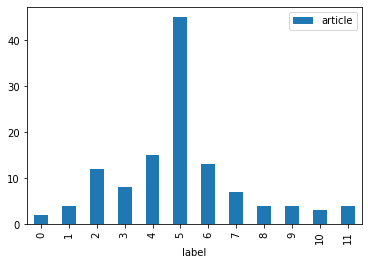

In [9]:
df.groupby('label').count().plot(kind='bar')

In [10]:
df[df['label'] == 5]

,label,article
1,5,[2208.08405] Pion spectroscopy and dynamics us...
3,5,[2208.08327] Prospects for $B^0_{(s)}\toπ^0π^0...
5,5,[2208.08296] Sneutrinos as two inflatons and c...
6,5,[2208.08278] MSW effect with quark matter: Neu...
7,5,[2208.08197] On sum rules for double and tripl...
10,5,"[2208.08137] Monopoles, Strings and Gravitatio..."
12,5,[2208.07990] Insights into the nature of the $...
13,5,[2208.07953] Opportunities for theory studies ...
15,5,"[2208.07910] When, Where, and How to Open Data..."
18,5,[2208.07878] Lepto-axiogenesis and the scale o...
